In [1]:

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint


2024-10-31 10:57:49.955189: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 10:57:50.148331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 10:57:50.220691: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 10:57:50.245164: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 10:57:50.371906: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Custom Dice coefficient
def DiceMetric():
    def dice_coef(y_true, y_pred):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)
    return dice_coef

# Custom IOU Metric
def IoUMetric():
    def iou_coef(y_true, y_pred):
        intersection = tf.keras.backend.sum(y_true * y_pred)
        union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
        return (intersection + 1e-6) / (union + 1e-6)
    return iou_coef


In [3]:
# Define the U-Net model with additional layers
def unet_model(input_size=(224, 224, 3)):
    inputs = layers.Input(input_size)

    # Encoder (Downsampling)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)  # New pooling layer added

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)  # New convolution layer added
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)  # New convolution layer added
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)  # New pooling layer added

    # Bridge
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)  # Increased filter size
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder (Upsampling)
    up1 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge1 = layers.concatenate([conv4, up1], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge1)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up2 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge2 = layers.concatenate([conv3, up2], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge2)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up3 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge3 = layers.concatenate([conv2, up3], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up4 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge4 = layers.concatenate([conv1, up4], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge4)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    output = layers.Conv2D(1, 1, activation='sigmoid')(conv9)  # Ensure sigmoid for binary masks

    model = models.Model(inputs=[inputs], outputs=[output])
    return model


In [4]:
# Compile the model with custom metrics
def compile_model_with_custom_metrics(model):
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss=binary_crossentropy,
                  metrics=[
                      'accuracy',  # Standard accuracy metric
                      tf.keras.metrics.MeanIoU(num_classes=2, name='mean_io_u'),
                      DiceMetric(),  # Custom Dice
                      IoUMetric(),   # Custom IoU
                      tf.keras.metrics.Precision(name='precision'), 
                      tf.keras.metrics.Recall(name='recall')
                  ])
    return model


In [5]:
# Load data function
def load_data(image_dir='data_aug/jpg_aug', mask_dir='data_aug/mask_aug', img_size=(224, 224)):
    images = []
    masks = []

    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename.replace('.jpg', '.png'))
            
            image = cv2.imread(img_path)
            image = cv2.resize(image, img_size)
            images.append(image)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size)
            mask = (mask > 0).astype(np.float32)  # Convert to binary and float32
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
            masks.append(mask)

    return np.array(images), np.array(masks)


In [6]:
# Visualize samples
def visualize_samples(images, masks, num_samples=5):
    plt.figure(figsize=(15, 10))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(images[i].astype('uint8'))
        plt.title('Image')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')  # Remove the channel dimension for masks
        plt.title('Mask')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

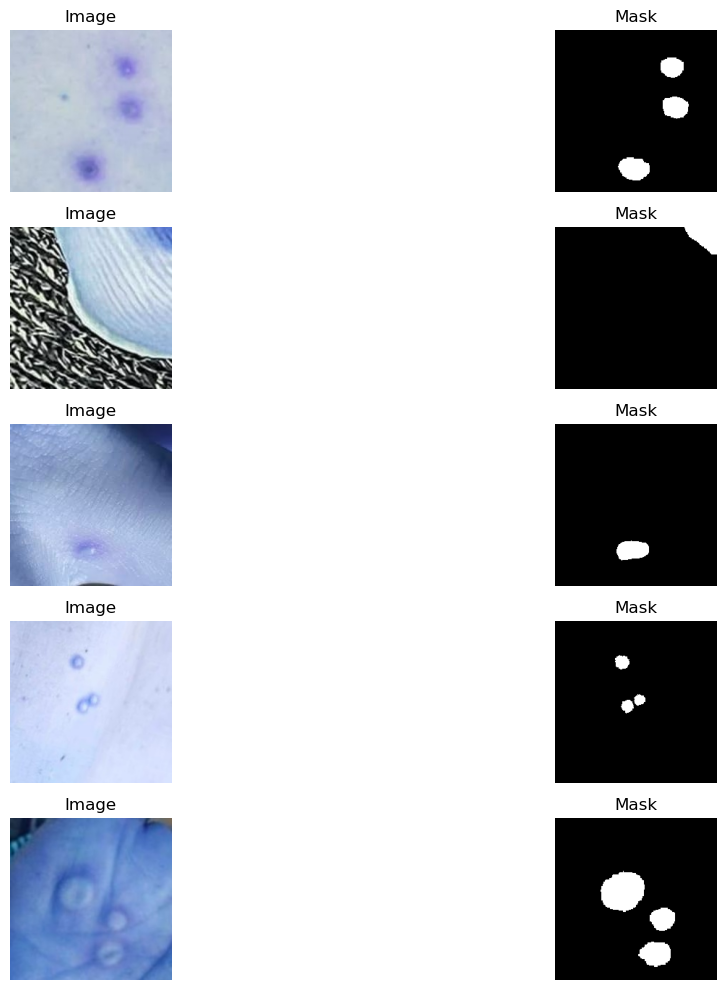

In [7]:
# Load data
x_train, y_train = load_data()

# Visualize a few samples
visualize_samples(x_train, y_train)

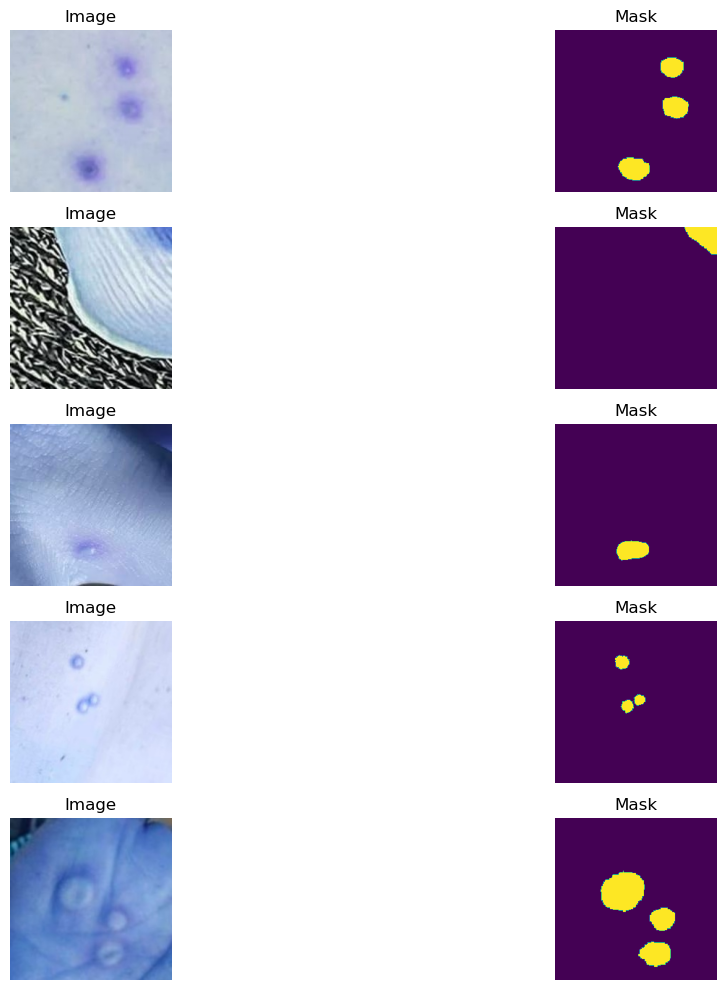

In [8]:
# Visualize samples
def visualize_samples(images, masks, num_samples=5):
    plt.figure(figsize=(15, 10))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(images[i].astype('uint8'))
        plt.title('Image')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(masks[i].squeeze())  # Remove the channel dimension for masks
        plt.title('Mask')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Load data
x_train, y_train = load_data()

# Visualize a few samples
visualize_samples(x_train, y_train)

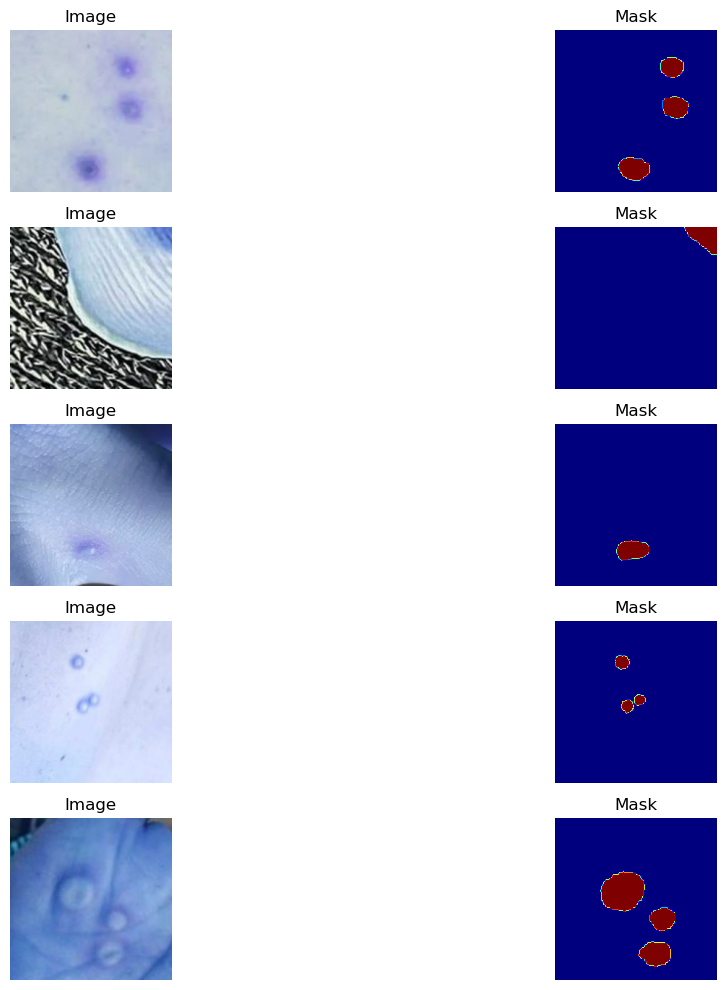

In [9]:
# Visualize samples with colorful masks
def visualize_samples(images, masks, num_samples=5):
    plt.figure(figsize=(15, 10))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(images[i].astype('uint8'))
        plt.title('Image')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(masks[i].squeeze(), cmap='jet')  # Use the 'jet' colormap for colorful masks
        plt.title('Mask')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
# Load data
x_train, y_train = load_data()

# Visualize a few samples
visualize_samples(x_train, y_train)

In [10]:
# Function to train the U-Net model with model saving
def train_unet(x_train, y_train, model, model_name, batch_size=4, epochs=50):
    # Define a ModelCheckpoint callback to save the best model
    checkpoint = ModelCheckpoint(f"best_{model_name}.keras", 
                                 monitor='val_loss',  # Monitor validation loss
                                 verbose=1,           # Print messages when saving the model
                                 save_best_only=True,  # Save only the best model
                                 mode='min')           # Save the model with minimum validation loss
    
    # Train the model with the ModelCheckpoint callback
    history = model.fit(x_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        validation_split=0.2, 
                        callbacks=[checkpoint])
    
    # Save model history (optional since best model is saved by checkpoint)
    np.save(f"{model_name}_history.npy", history.history)
    
    return model, history


In [11]:
# Load data
x_train, y_train = load_data()

# Create Model 1: U-Net with custom Dice, IoU, Precision, Recall
unet_custom = unet_model()
unet_custom = compile_model_with_custom_metrics(unet_custom)
unet_custom.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 14, 14,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 28, 28,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_7[0][0], 

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

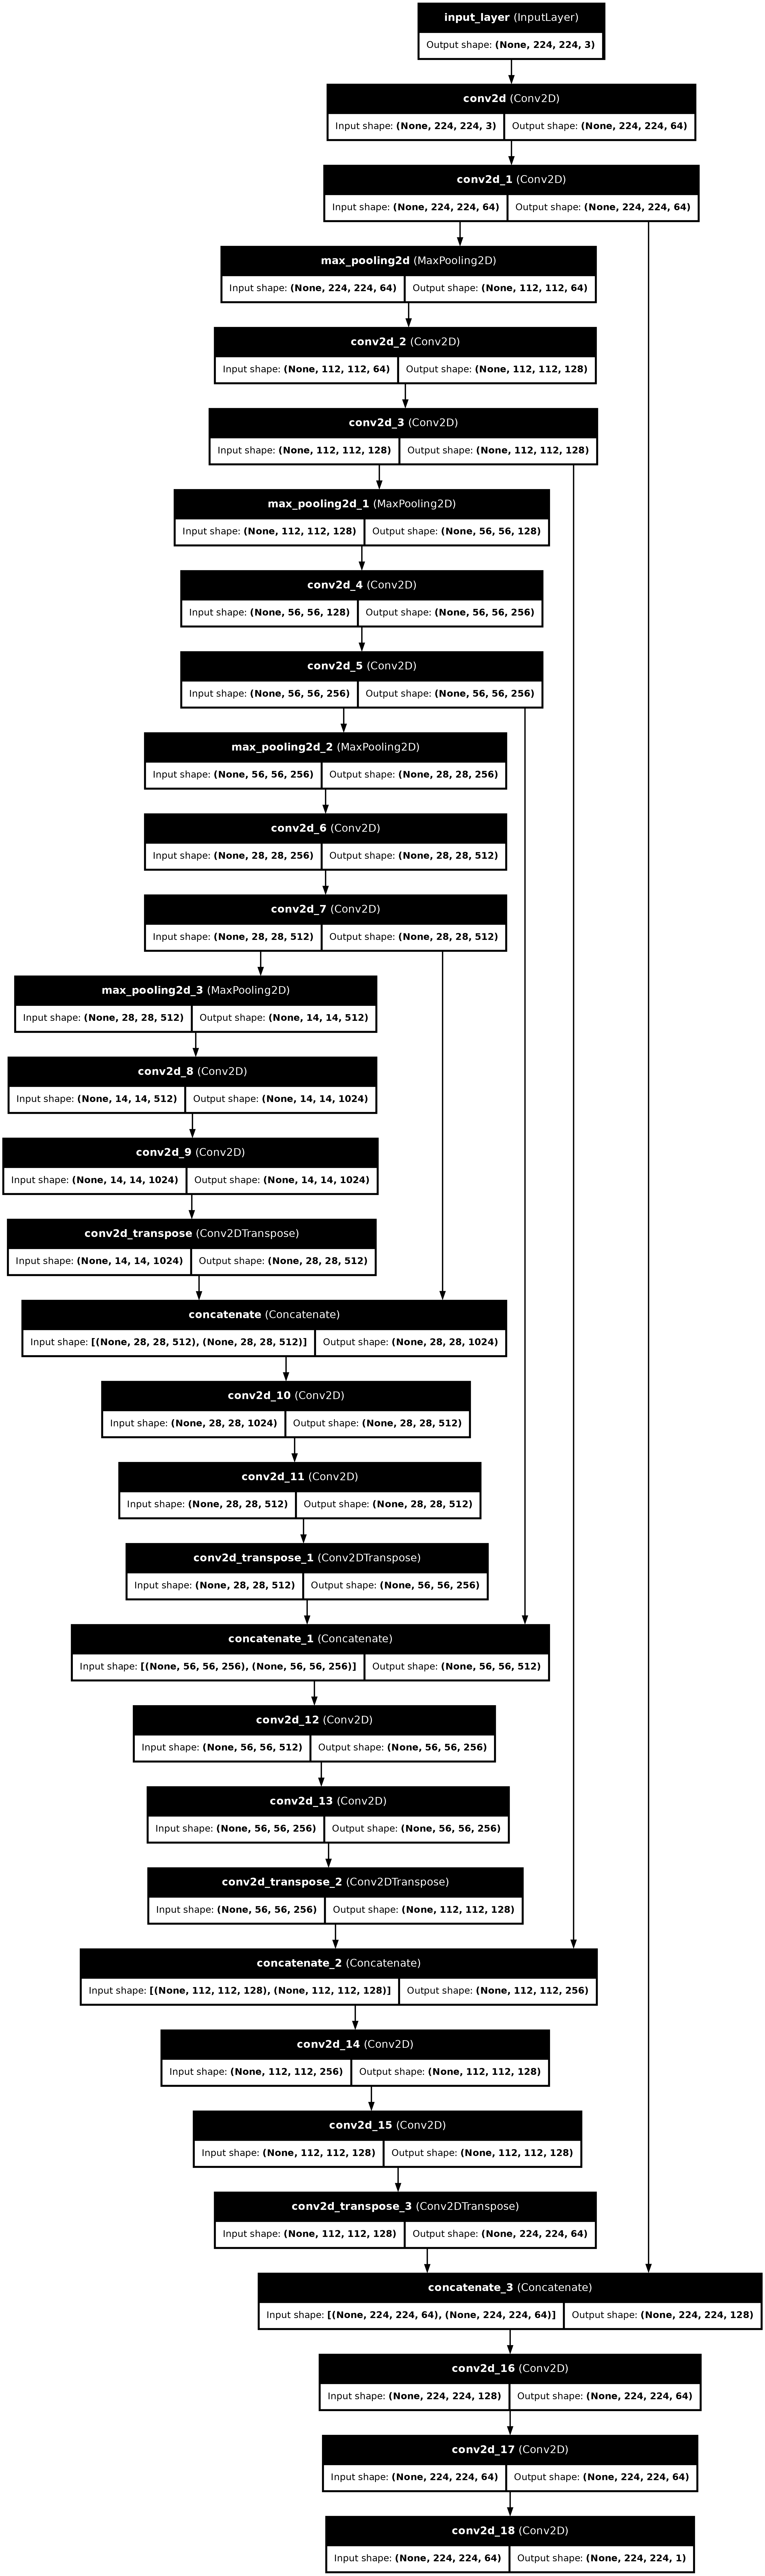

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(unet_custom, to_file='unet_model_architecture.png', show_shapes=True, show_layer_names=True)

In [13]:
unet_custom, history_custom = train_unet(x_train, y_train, unet_custom, "unet_custom")

Epoch 1/50


/home/salman/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9243 - dice_coef: 0.1075 - iou_coef: 0.0585 - loss: 0.3540 - mean_io_u: 0.4642 - precision: 0.2646 - recall: 0.0314
Epoch 1: val_loss improved from inf to 0.25365, saving model to best_unet_custom.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.9244 - dice_coef: 0.1077 - iou_coef: 0.0586 - loss: 0.3529 - mean_io_u: 0.4643 - precision: 0.2653 - recall: 0.0314 - val_accuracy: 0.9230 - val_dice_coef: 0.1349 - val_iou_coef: 0.0740 - val_loss: 0.2536 - val_mean_io_u: 0.4616 - val_precision: 0.4791 - val_recall: 0.0140
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9267 - dice_coef: 0.1666 - iou_coef: 0.0927 - loss: 0.2275 - mean_io_u: 0.4648 - precision: 0.3816 - recall: 0.0602
Epoch 2: val_loss did not improve from 0.25365
89/89 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.9268 - dice_coef: 0.1665 - iou_coef: 0.0927 - loss: 0.2273 - mean_io_u: 0.4648 - precision: 0.3815 - recall: 0.0603 - val_accuracy: 0.923

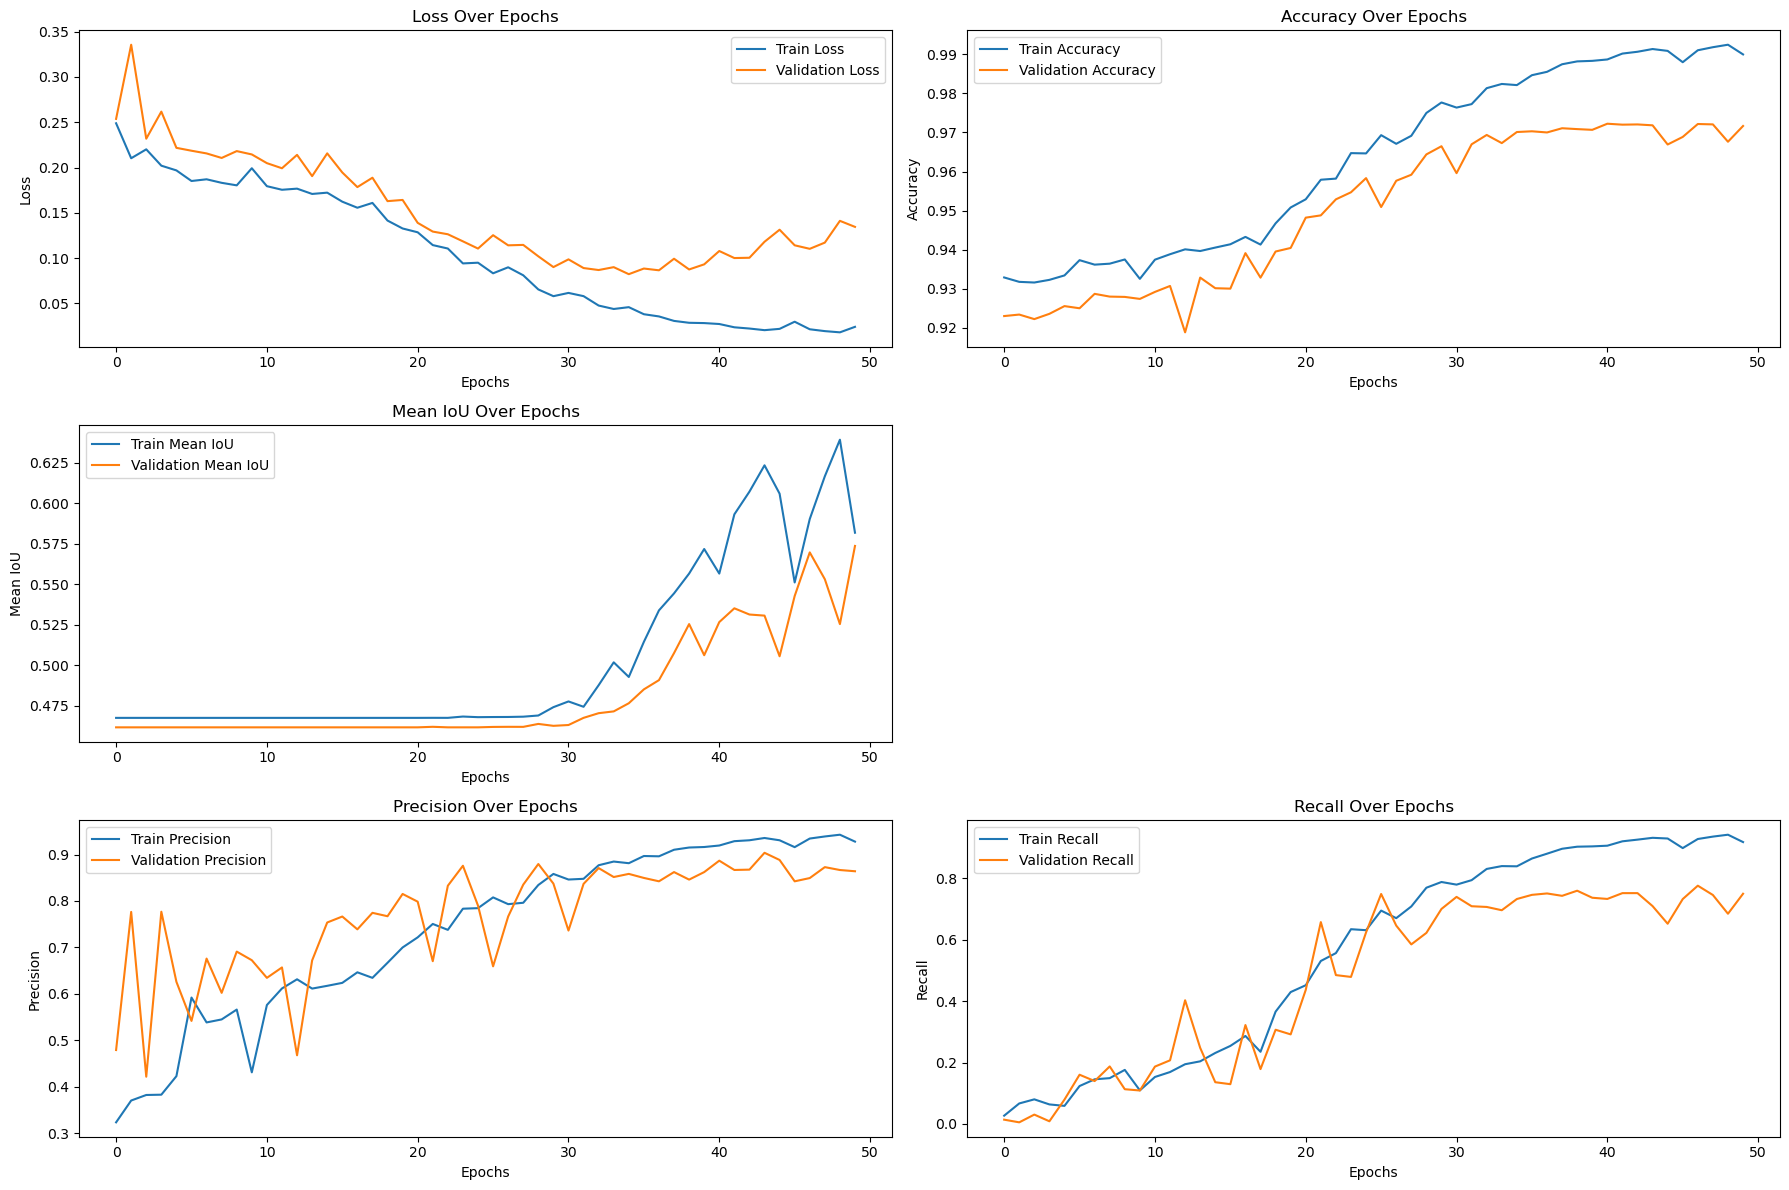

In [14]:
# Function to plot all relevant metrics
def plot_training_history(history):
    plt.figure(figsize=(18, 12))

    # Plot loss
    plt.subplot(3, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(3, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Mean IoU if available
    if 'mean_io_u' in history:
        plt.subplot(3, 2, 3)
        plt.plot(history['mean_io_u'], label='Train Mean IoU')
        plt.plot(history['val_mean_io_u'], label='Validation Mean IoU')
        plt.title('Mean IoU Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()
    
    # Plot Dice Coefficient if available
    if 'dice_metric' in history:
        plt.subplot(3, 2, 4)
        plt.plot(history['dice_metric'], label='Train Dice Coefficient')
        plt.plot(history['val_dice_metric'], label='Validation Dice Coefficient')
        plt.title('Dice Coefficient Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Coefficient')
        plt.legend()
    
    # Plot Precision if available
    if 'precision' in history:
        plt.subplot(3, 2, 5)
        plt.plot(history['precision'], label='Train Precision')
        plt.plot(history['val_precision'], label='Validation Precision')
        plt.title('Precision Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()

    # Plot Recall if available
    if 'recall' in history:
        plt.subplot(3, 2, 6)
        plt.plot(history['recall'], label='Train Recall')
        plt.plot(history['val_recall'], label='Validation Recall')
        plt.title('Recall Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function after training
plot_training_history(history_custom.history)


14/14 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step


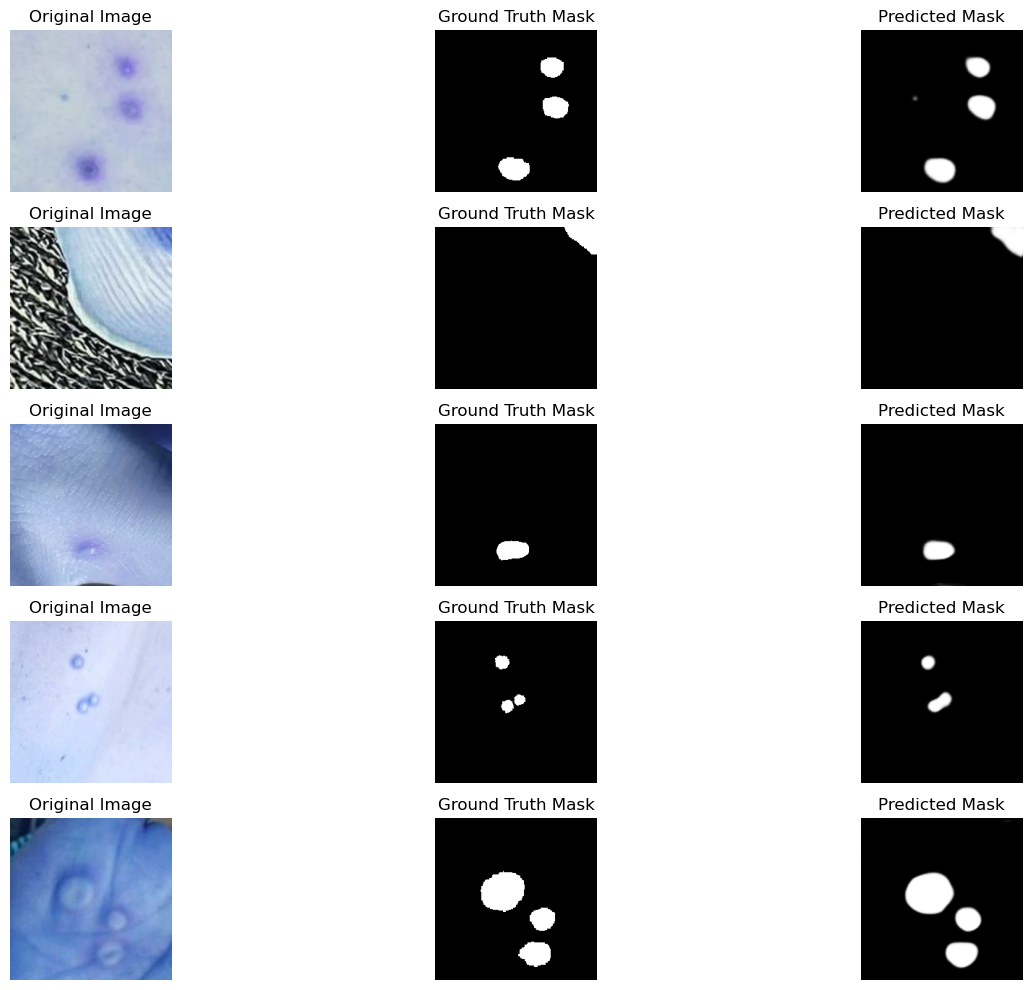

In [15]:
import matplotlib.pyplot as plt

def visualize_predictions(model, x, y, num_images=5):
    # Get predictions
    predictions = model.predict(x)
    
    # Set up the plot
    plt.figure(figsize=(15, 10))
    
    for i in range(num_images):
        # Original image
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(x[i].squeeze(), cmap='gray')
        plt.title("Original Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(y[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call the visualization function after training
visualize_predictions(unet_custom, x_train, y_train)


14/14 ━━━━━━━━━━━━━━━━━━━━ 64s 5s/step


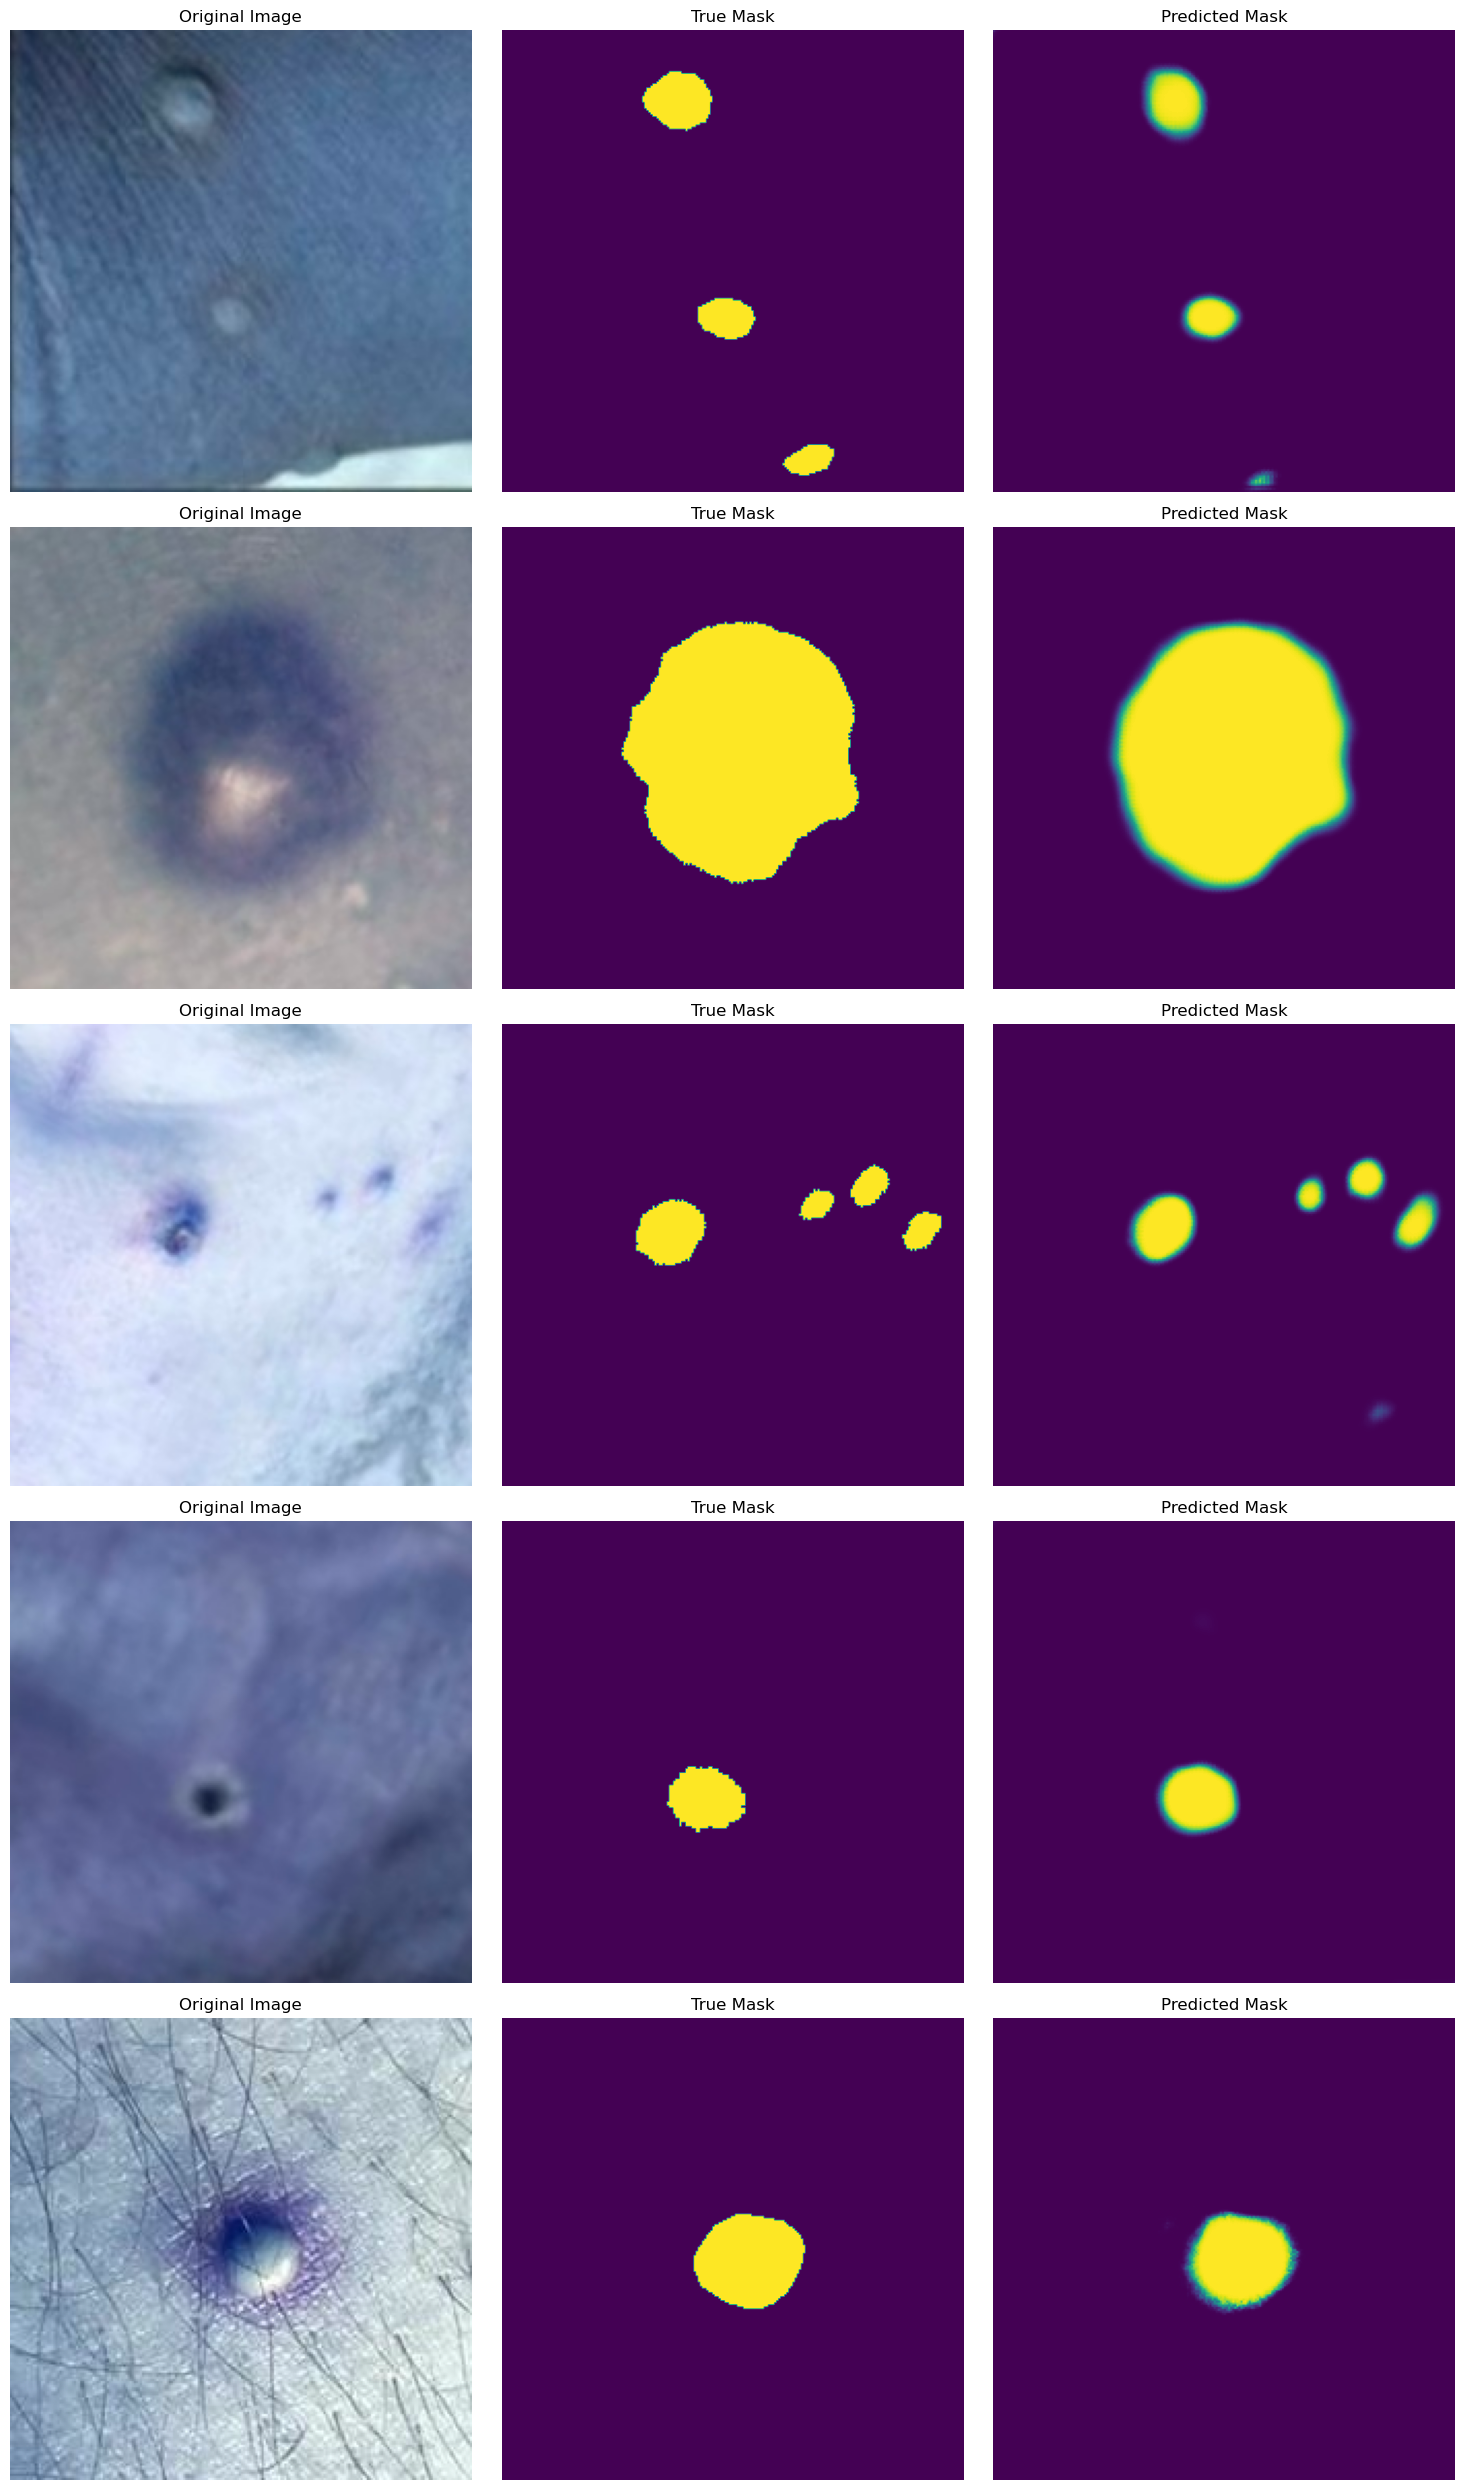

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Function to visualize the image, true mask, and predicted mask
def visualize_results(images, true_masks, predicted_masks, num_images=5):
    # Randomly select images to visualize
    indices = np.random.choice(range(len(images)), num_images, replace=False)
    
    plt.figure(figsize=(15, num_images * 5))
    
    for i, idx in enumerate(indices):
        # Display the original image
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(images[idx].astype('float32') / 255.0)  # Normalize if needed
        plt.title("Original Image")
        plt.axis('off')

        # Display the true mask
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(true_masks[idx].astype('float32'))  # Assuming masks are already binary
        plt.title("True Mask")
        plt.axis('off')

        # Display the predicted mask
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(predicted_masks[idx].astype('float32'))  # Assuming masks are binary
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming you have the test data (x_test) to predict
# Generate predicted masks using the trained model
predicted_masks = unet_custom.predict(x_train)  # Use your validation/test set if available

# Visualize results
visualize_results(x_train, y_train, predicted_masks)


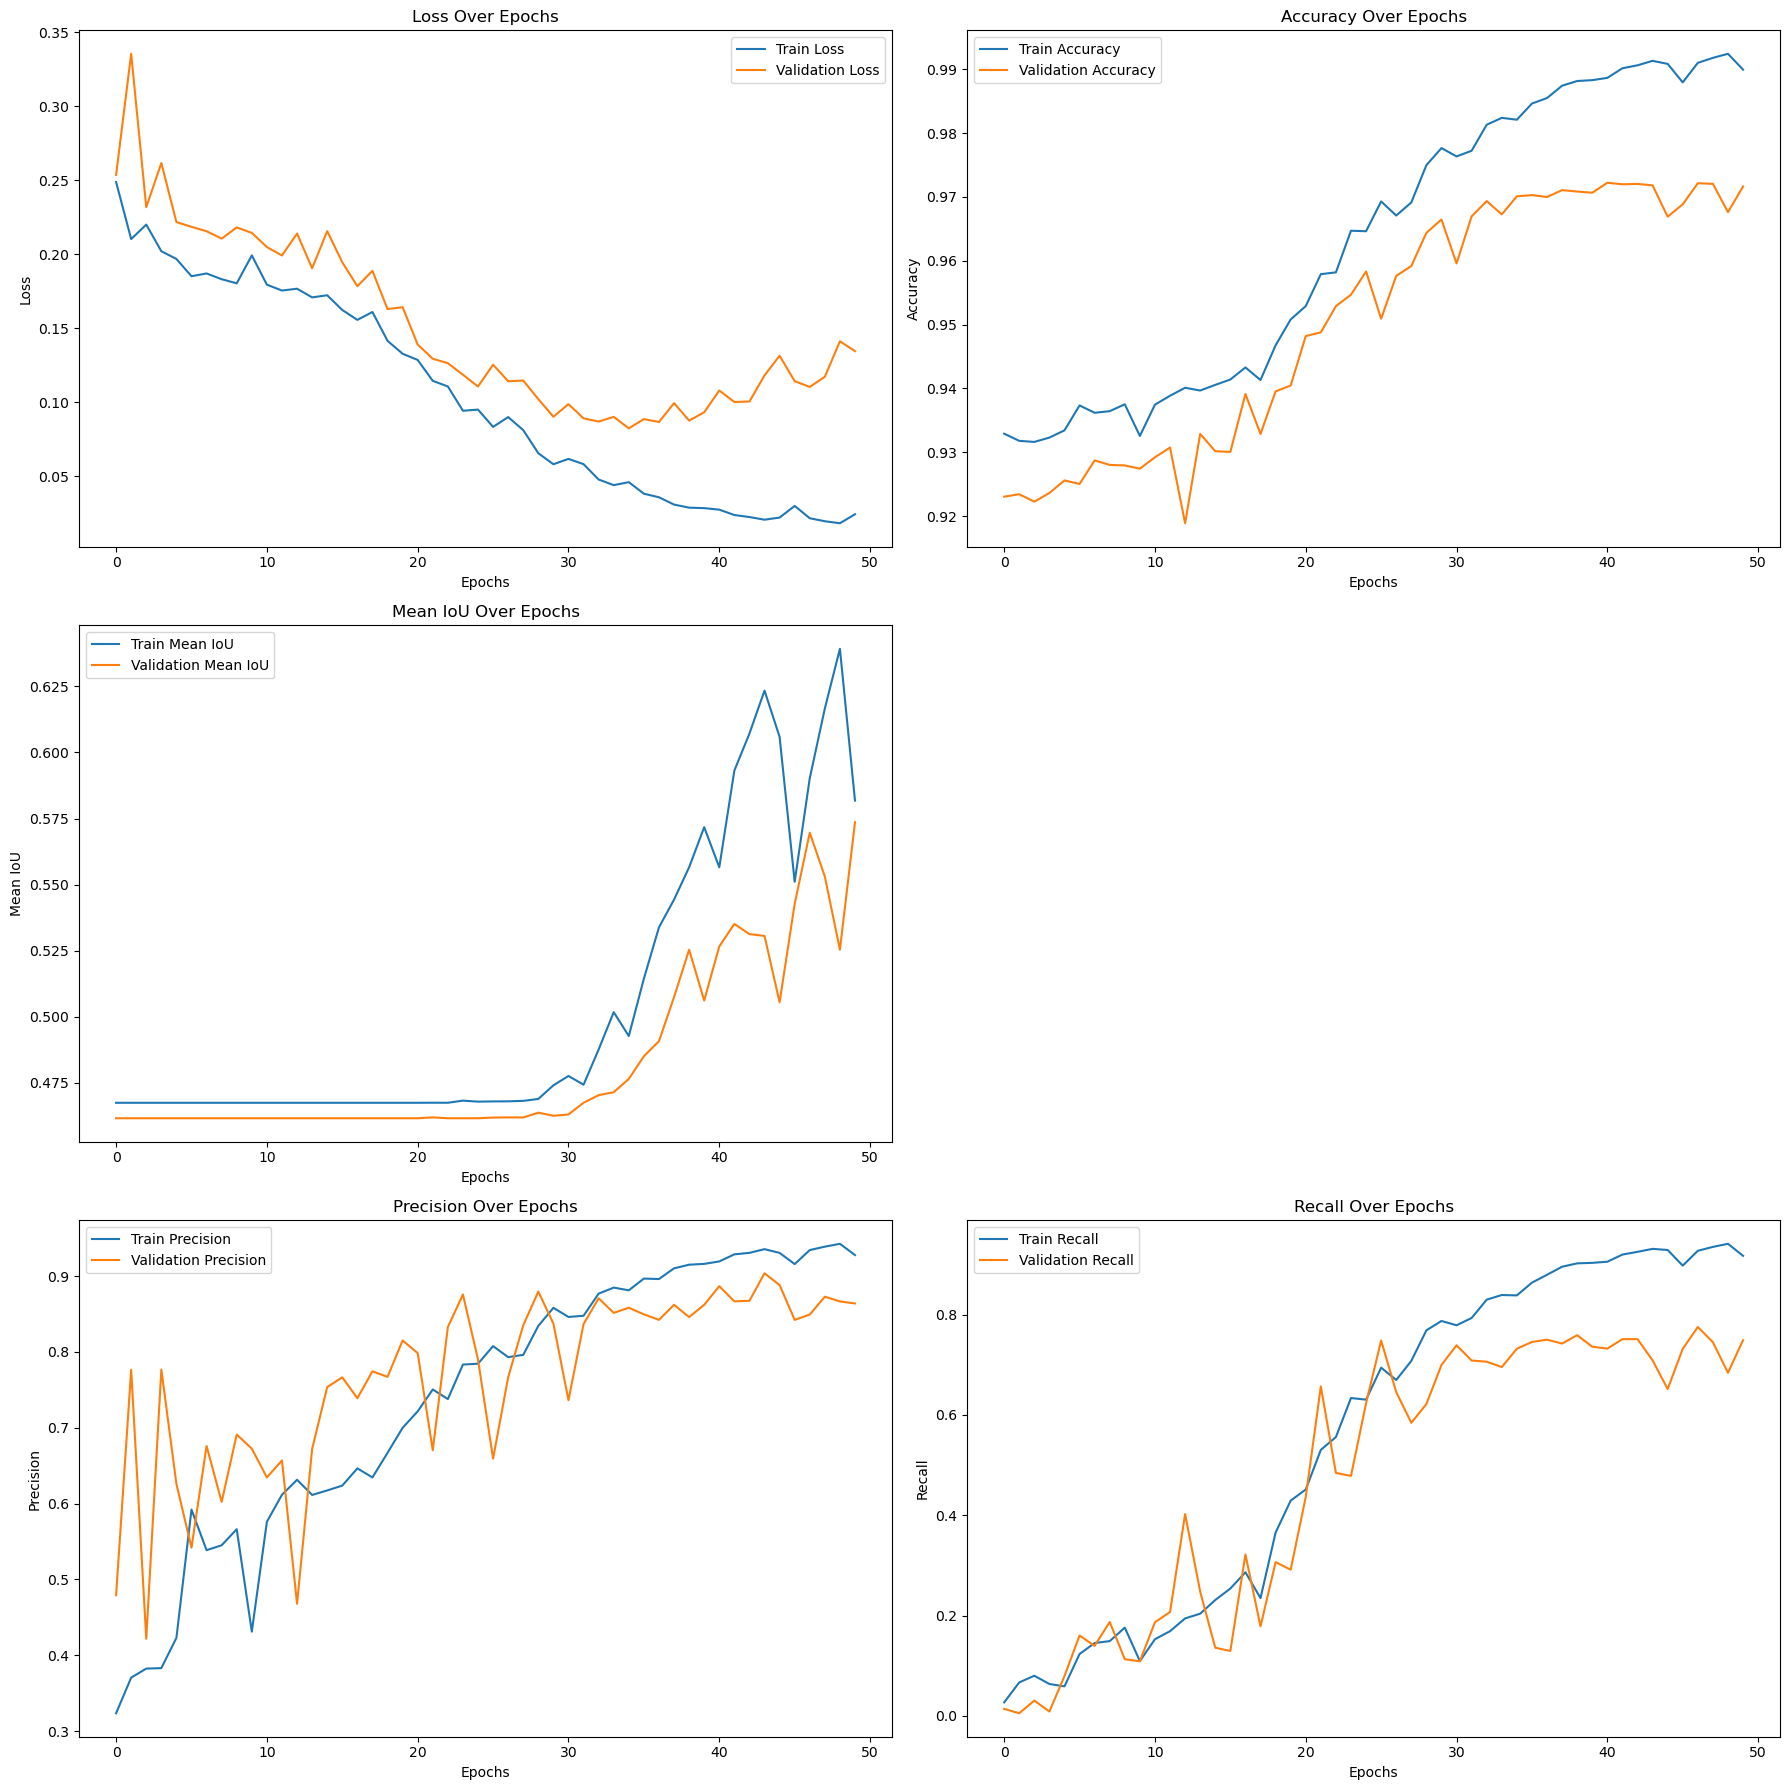

KeyError: 'dice_metric'

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot training metrics (loss, accuracy, etc.) over epochs
def plot_training_history(history):
    plt.figure(figsize=(18, 18))

    # Loss plot
    plt.subplot(3, 2, 1)
    plt.plot(history.get('loss', []), label='Train Loss')
    plt.plot(history.get('val_loss', []), label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(3, 2, 2)
    plt.plot(history.get('accuracy', []), label='Train Accuracy')
    plt.plot(history.get('val_accuracy', []), label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Mean IoU plot
    if 'mean_io_u' in history:
        plt.subplot(3, 2, 3)
        plt.plot(history.get('mean_io_u', []), label='Train Mean IoU')
        plt.plot(history.get('val_mean_io_u', []), label='Validation Mean IoU')
        plt.title('Mean IoU Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()
    
    # Dice Coefficient plot
    if 'dice_metric' in history:
        plt.subplot(3, 2, 4)
        plt.plot(history.get('dice_metric', []), label='Train Dice Coefficient')
        plt.plot(history.get('val_dice_metric', []), label='Validation Dice Coefficient')
        plt.title('Dice Coefficient Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Coefficient')
        plt.legend()
    
    # Precision plot
    if 'precision' in history:
        plt.subplot(3, 2, 5)
        plt.plot(history.get('precision', []), label='Train Precision')
        plt.plot(history.get('val_precision', []), label='Validation Precision')
        plt.title('Precision Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()

    # Recall plot
    if 'recall' in history:
        plt.subplot(3, 2, 6)
        plt.plot(history.get('recall', []), label='Train Recall')
        plt.plot(history.get('val_recall', []), label='Validation Recall')
        plt.title('Recall Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Function to display sample predictions (overlay true and predicted masks)
def display_sample_predictions(model, sample_images, sample_masks):
    plt.figure(figsize=(15, 15))
    num_samples = len(sample_images)
    for i in range(num_samples):
        img = sample_images[i]
        true_mask = sample_masks[i]
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]

        # Original Image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')

        # True Mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Function to plot metric distribution (Box plots for metrics)
def plot_metric_distribution(metric_values, metric_name):
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=metric_values, palette="Set2")
    plt.title(f'{metric_name} Distribution')
    plt.xlabel('Metric Value')
    plt.ylabel(metric_name)
    plt.show()

# Confusion Matrix for Pixel-level Prediction
def plot_pixel_confusion_matrix(true_masks, pred_masks, threshold=0.5):
    # Flatten arrays to binary values for confusion matrix
    true_flat = np.concatenate([mask.flatten() for mask in true_masks])
    pred_flat = np.concatenate([(pred > threshold).flatten() for pred in pred_masks])

    # Compute confusion matrix
    cm = confusion_matrix(true_flat, pred_flat)
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.title("Pixel-level Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Example usage with array inputs
# Assuming `history_custom.history` contains training metrics, 
# `sample_images` and `sample_masks` are arrays of sample images and masks,
# and `metric_values` is a dictionary of metric lists for distribution plots.
plot_training_history(history_custom.history)

# Load `sample_images` and `sample_masks` as arrays here:
# Example: sample_images = [image_1_array, image_2_array, ...]
# display_sample_predictions(unet_custom, sample_images, sample_masks)

# Plot Metric Distributions
plot_metric_distribution(history_custom.history['dice_metric'], "Dice Coefficient")
plot_metric_distribution(history_custom.history['iou_coef'], "IoU Coefficient")

# Optional: Plot Pixel-level Confusion Matrix if necessary
# Assuming true_masks and pred_masks are binary arrays of true and predicted masks
# plot_pixel_confusion_matrix(sample_masks, sample_predictions)


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Figure 1: Display Example Predictions (Original Image, Ground Truth Mask, Predicted Mask)
def display_predictions(model, sample_images, sample_masks):
    if not sample_images or not sample_masks:
        print("No sample images or masks to display.")
        return
    
    plt.figure(figsize=(15, 15))
    num_samples = len(sample_images)
    for i in range(num_samples):
        img = sample_images[i]
        true_mask = sample_masks[i]
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]

        # Original Image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')

        # True Mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Figure 2: Plot Training History (Loss and Dice Coefficient Curves)
def plot_training_metrics(history):
    if not history:
        print("No training history available.")
        return
    
    plt.figure(figsize=(12, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.get('loss', []), label='Training Loss')
    plt.plot(history.get('val_loss', []), label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Dice Coefficient
    plt.subplot(1, 2, 2)
    plt.plot(history.get('dice_metric', []), label='Training Dice')
    plt.plot(history.get('val_dice_metric', []), label='Validation Dice')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.title('Dice Coefficient Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Figure 3: Box Plot for Metric Distribution
def plot_metric_distribution(metrics, metric_name):
    if metrics is None or len(metrics) == 0:
        print(f"No data for metric: {metric_name}")
        return
    
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=metrics, palette="Set2")
    plt.title(f'{metric_name} Distribution')
    plt.xlabel(metric_name)
    plt.ylabel('Value')
    plt.show()

# Figure 4 (Optional): Overlay Visualization for Severity
def display_severity_overlay(images, masks, severity_scores):
    if not images or not masks or not severity_scores:
        print("Missing data for severity overlay.")
        return
    
    plt.figure(figsize=(15, 10))
    num_samples = len(images)
    for i in range(num_samples):
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis('off')

        plt.subplot(3, num_samples, num_samples + i + 1)
        plt.imshow(masks[i], cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(3, num_samples, 2 * num_samples + i + 1)
        plt.imshow(images[i], alpha=0.7)
        plt.imshow(masks[i], cmap='hot', alpha=0.5)
        plt.title(f"Severity: {severity_scores[i]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Figure 1: Display predictions
display_predictions(unet_custom, sample_images, sample_masks)

# Figure 2: Plot training metrics
plot_training_metrics(history)

# Figure 3: Plot metric distribution (example using 'Dice' scores)
plot_metric_distribution(metrics, "Dice")

# Figure 4: Display severity overlays (optional)
display_severity_overlay(sample_images, sample_masks, severity_scores)

NameError: name 'sample_images' is not defined

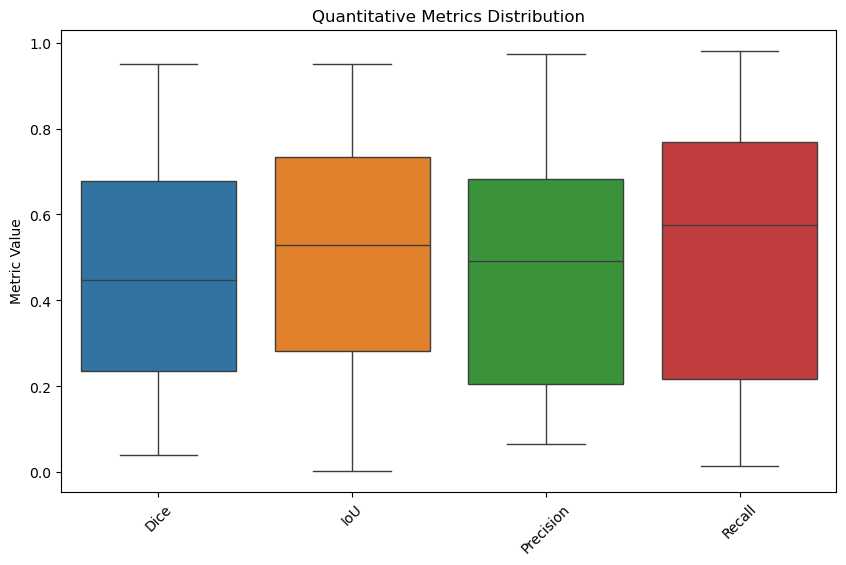

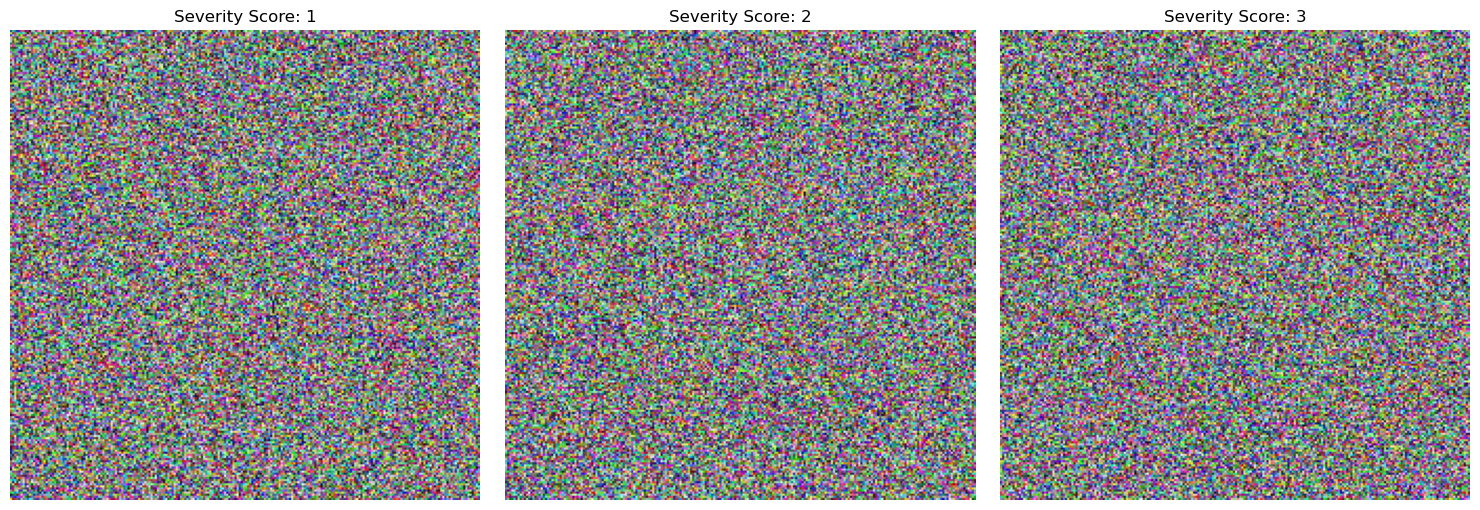

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data (replace these with your actual metrics)
# For box plots, assume metrics is a DataFrame with columns for each metric
import pandas as pd

# Example metrics DataFrame
data = {
    'Dice': np.random.rand(50),
    'IoU': np.random.rand(50),
    'Precision': np.random.rand(50),
    'Recall': np.random.rand(50)
}
metrics = pd.DataFrame(data)

# Example severity scores and images (replace with your actual data)
sample_images = [np.random.rand(224, 224, 3) for _ in range(3)]  # Replace with actual images
severity_scores = [1, 2, 3]  # Example severity scores for overlay

# Function to plot box plots for metrics
def plot_metric_distribution(metrics):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=metrics)
    plt.title('Quantitative Metrics Distribution')
    plt.ylabel('Metric Value')
    plt.xticks(rotation=45)
    plt.show()

# Function to display severity overlay
def display_severity_overlay(images, severity_scores):
    plt.figure(figsize=(15, 5))
    
    for i, (image, score) in enumerate(zip(images, severity_scores)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image)
        plt.title(f'Severity Score: {score}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the functions
# Figure 3: Box plots for quantitative metrics across the test set
plot_metric_distribution(metrics)

# Figure 4: Severity overlay visualization on sample cases
display_severity_overlay(sample_images, severity_scores)


Severity Percentage: 0.02%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


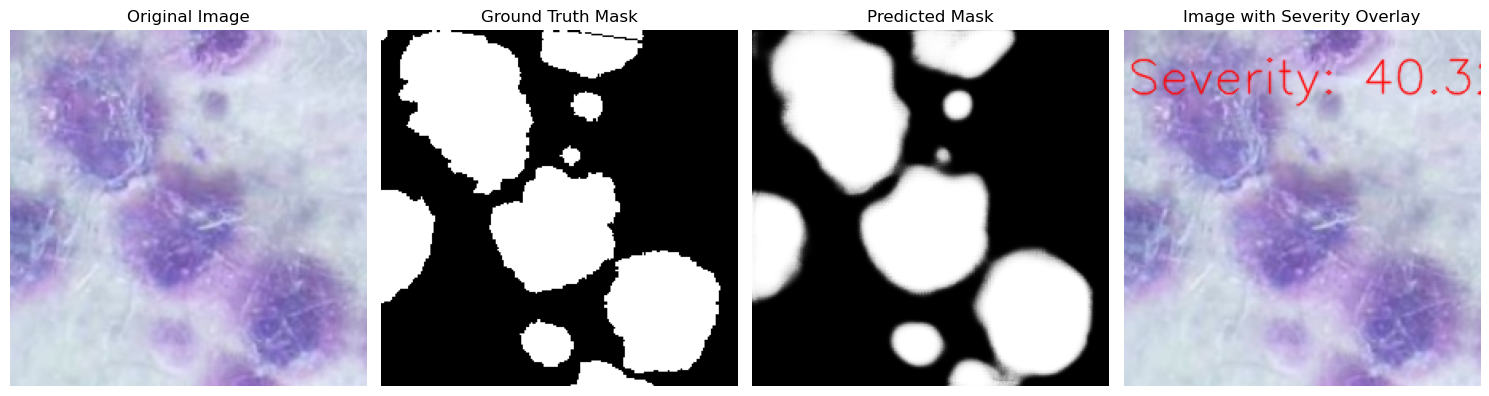

In [35]:
import cv2


def generate_heatmap(model, image):
    # Preprocess the image for the model
    image_input = np.expand_dims(image, axis=0)  # Add batch dimension
    image_input = image_input / 255.0  # Normalize the image

    # Get the last convolutional layer's output
    last_conv_layer = model.get_layer('conv2d_18')  # Change this to the correct layer name--last layer
    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_input)
        loss = predictions[0]  # Use the predicted mask

    # Calculate the gradients of the loss with respect to the convolutional outputs
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))  # Global Average Pooling

    # Create a heatmap
    heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.reduce_mean(heatmap, axis=-1)  # Average over channels
    heatmap = tf.maximum(heatmap, 0)  # ReLU
    heatmap /= tf.reduce_max(heatmap)  # Normalize to [0, 1]

    return heatmap.numpy()

# Load a test image (replace index with the desired test image index)
test_image = x_train[1]  # Example: Using the first training image


def calculate_severity(heatmap, threshold=0.5):
    # Binarize the heatmap based on the threshold
    binary_heatmap = heatmap > threshold
    
    # Calculate the area of the heatmap
    area_of_heatmap = np.sum(binary_heatmap)
    
    # Calculate the total area of the image
    total_area = heatmap.size
    
    # Calculate the percentage of affected area
    severity_percentage = (area_of_heatmap / total_area) * 100
    
    return severity_percentage

# Example usage
heatmap = generate_heatmap(unet_custom, test_image)  # Get the heatmap for a specific test image
severity_percentage = calculate_severity(heatmap)

print(f"Severity Percentage: {severity_percentage:.2f}%")




def overlay_severity(image, severity_percentage):
    severity_text = f"Severity: {severity_percentage:.2f}%"
    position = (2, 40)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (255, 0, 0)  # Red color
    thickness = 1
    line_type = cv2.LINE_AA
    cv2.putText(image, severity_text, position, font, font_scale, font_color, thickness, line_type)
    return image

def visualize_with_masks(image, true_mask, predicted_mask, severity_percentage):
    # Overlay severity on the original image
    image_with_severity = overlay_severity(image.copy(), severity_percentage)

    plt.figure(figsize=(15, 10))

    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(image.astype('uint8'))
    plt.title("Original Image")
    plt.axis("off")

    # Ground Truth Mask
    plt.subplot(1, 4, 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Predicted Mask
    plt.subplot(1, 4, 3)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    # Image with Severity Overlay
    plt.subplot(1, 4, 4)
    plt.imshow(image_with_severity)
    plt.title("Image with Severity Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
test_image = x_train[9]  # Replace with your actual test image
true_mask = y_train[9]   # Corresponding true mask
predicted_mask = unet_custom.predict(np.expand_dims(test_image, axis=0))[0]  # Get predicted mask
severity_percentage = calculate_severity(predicted_mask)  # Calculate severity from predicted mask

# Visualize with masks and severity
visualize_with_masks(test_image, true_mask, predicted_mask, severity_percentage)


Severity Percentage: 0.02%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


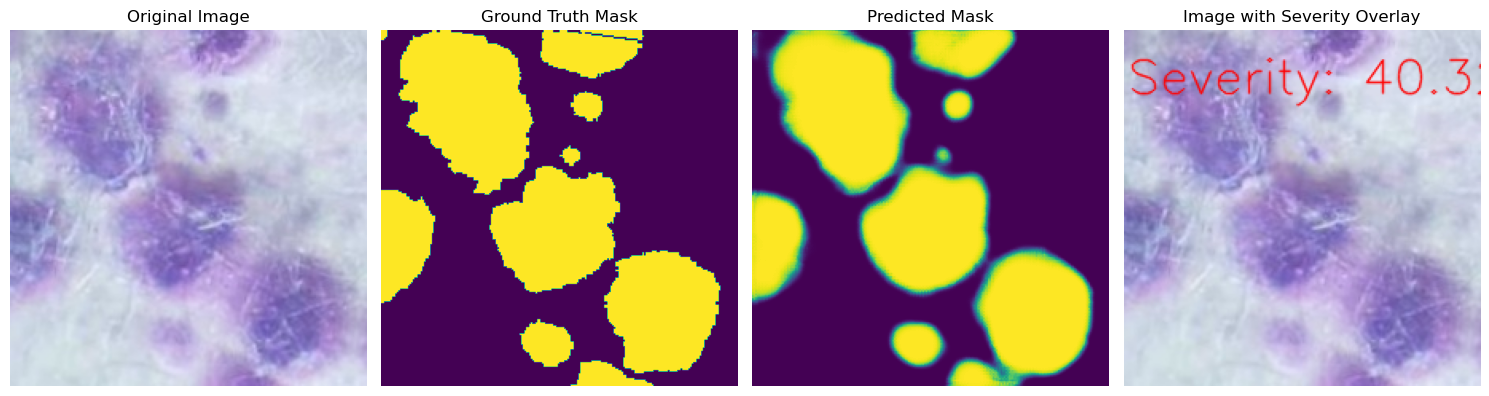

In [36]:
import cv2


def generate_heatmap(model, image):
    # Preprocess the image for the model
    image_input = np.expand_dims(image, axis=0)  # Add batch dimension
    image_input = image_input / 255.0  # Normalize the image

    # Get the last convolutional layer's output
    last_conv_layer = model.get_layer('conv2d_18')  # Change this to the correct layer name--last layer
    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_input)
        loss = predictions[0]  # Use the predicted mask

    # Calculate the gradients of the loss with respect to the convolutional outputs
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))  # Global Average Pooling

    # Create a heatmap
    heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.reduce_mean(heatmap, axis=-1)  # Average over channels
    heatmap = tf.maximum(heatmap, 0)  # ReLU
    heatmap /= tf.reduce_max(heatmap)  # Normalize to [0, 1]

    return heatmap.numpy()

# Load a test image (replace index with the desired test image index)
test_image = x_train[1]  # Example: Using the first training image


def calculate_severity(heatmap, threshold=0.5):
    # Binarize the heatmap based on the threshold
    binary_heatmap = heatmap > threshold
    
    # Calculate the area of the heatmap
    area_of_heatmap = np.sum(binary_heatmap)
    
    # Calculate the total area of the image
    total_area = heatmap.size
    
    # Calculate the percentage of affected area
    severity_percentage = (area_of_heatmap / total_area) * 100
    
    return severity_percentage

# Example usage
heatmap = generate_heatmap(unet_custom, test_image)  # Get the heatmap for a specific test image
severity_percentage = calculate_severity(heatmap)

print(f"Severity Percentage: {severity_percentage:.2f}%")




def overlay_severity(image, severity_percentage):
    severity_text = f"Severity: {severity_percentage:.2f}%"
    position = (2, 40)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (255, 0, 0)  # Red color
    thickness = 1
    line_type = cv2.LINE_AA
    cv2.putText(image, severity_text, position, font, font_scale, font_color, thickness, line_type)
    return image

def visualize_with_masks(image, true_mask, predicted_mask, severity_percentage):
    # Overlay severity on the original image
    image_with_severity = overlay_severity(image.copy(), severity_percentage)

    plt.figure(figsize=(15, 10))

    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(image.astype('uint8'))
    plt.title("Original Image")
    plt.axis("off")

    # Ground Truth Mask
    plt.subplot(1, 4, 2)
    plt.imshow(true_mask.squeeze())
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Predicted Mask
    plt.subplot(1, 4, 3)
    plt.imshow(predicted_mask.squeeze())
    plt.title("Predicted Mask")
    plt.axis("off")

    # Image with Severity Overlay
    plt.subplot(1, 4, 4)
    plt.imshow(image_with_severity)
    plt.title("Image with Severity Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
test_image = x_train[9]  # Replace with your actual test image
true_mask = y_train[9]   # Corresponding true mask
predicted_mask = unet_custom.predict(np.expand_dims(test_image, axis=0))[0]  # Get predicted mask
severity_percentage = calculate_severity(predicted_mask)  # Calculate severity from predicted mask

# Visualize with masks and severity
visualize_with_masks(test_image, true_mask, predicted_mask, severity_percentage)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


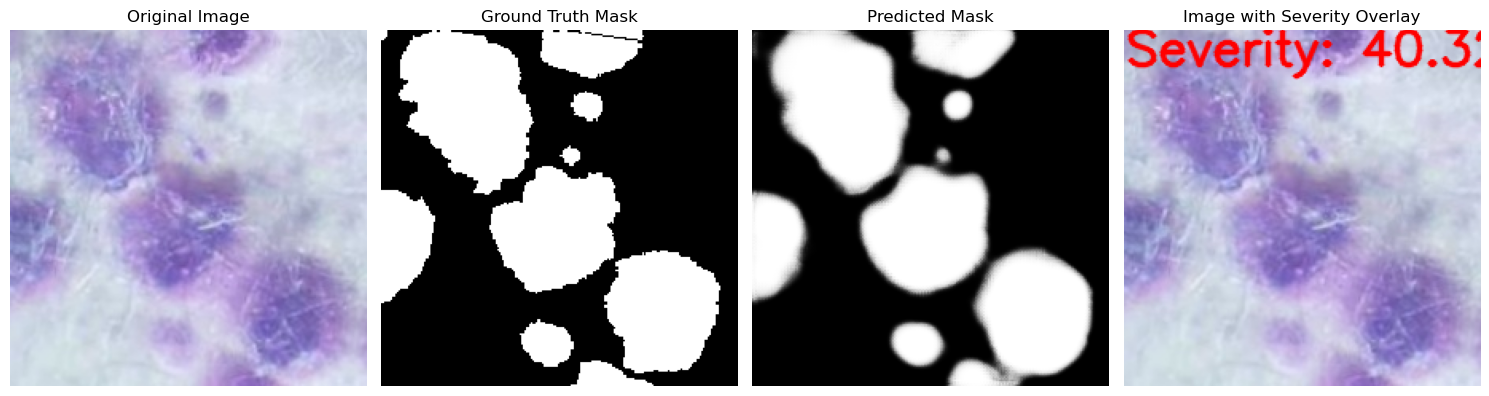

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_severity(mask, threshold=0.5):
    # Binarize the mask based on the threshold
    binary_mask = mask > threshold
    
    # Calculate the area of the mask
    area_of_mask = np.sum(binary_mask)
    
    # Calculate the total area of the image
    total_area = mask.size
    
    # Calculate the percentage of affected area
    severity_percentage = (area_of_mask / total_area) * 100
    
    return severity_percentage

def overlay_severity(image, severity_percentage):
    severity_text = f"Severity: {severity_percentage:.2f}%"
    position = (1, 22)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (255, 0, 0)  # Red color
    thickness = 2
    line_type = cv2.LINE_AA
    cv2.putText(image, severity_text, position, font, font_scale, font_color, thickness, line_type)
    return image

def visualize_with_masks(image, true_mask, predicted_mask, severity_percentage):
    # Overlay severity on the original image
    image_with_severity = overlay_severity(image.copy(), severity_percentage)

    plt.figure(figsize=(15, 10))

    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(image.astype('uint8'))
    plt.title("Original Image")
    plt.axis("off")

    # Ground Truth Mask
    plt.subplot(1, 4, 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Predicted Mask
    plt.subplot(1, 4, 3)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    # Image with Severity Overlay
    plt.subplot(1, 4, 4)
    plt.imshow(image_with_severity)
    plt.title("Image with Severity Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
test_image = x_train[9]  # Replace with your actual test image
true_mask = y_train[9]   # Corresponding true mask
predicted_mask = unet_custom.predict(np.expand_dims(test_image, axis=0))[0]  # Get predicted mask
severity_percentage = calculate_severity(predicted_mask)  # Calculate severity from predicted mask

# Visualize with masks and severity
visualize_with_masks(test_image, true_mask, predicted_mask, severity_percentage)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Enhanced Severity Percentage: 40.19%


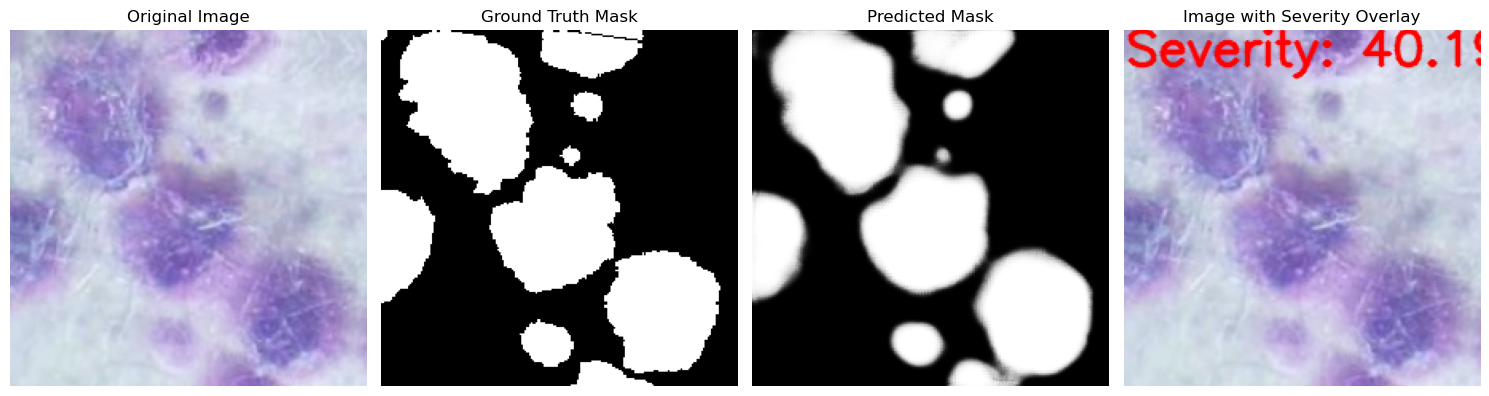

In [41]:
import numpy as np

def calculate_severity_enhanced(predicted_mask, thresholds=[0.3, 0.5, 0.7]):
    """
    Calculate severity by binarizing the predicted mask at multiple thresholds
    and averaging the affected areas to account for different lesion intensities.
    
    Args:
    - predicted_mask: The predicted mask from the model.
    - thresholds: A list of thresholds to apply for calculating severity at different levels.

    Returns:
    - severity_percentage: The calculated percentage of the affected area.
    """
    
    # Ensure the predicted mask is normalized (between 0 and 1)
    predicted_mask = np.clip(predicted_mask, 0, 1)

    # Initialize a list to store the severity percentage at each threshold
    severity_list = []

    total_area = predicted_mask.size  # Total area of the image

    for threshold in thresholds:
        # Binarize the mask at the current threshold
        binary_mask = predicted_mask > threshold

        # Calculate the area of the mask (i.e., affected area)
        area_of_mask = np.sum(binary_mask)

        # Calculate the percentage of the affected area
        severity_percentage = (area_of_mask / total_area) * 100
        severity_list.append(severity_percentage)

    # Return the average severity over all thresholds
    avg_severity_percentage = np.mean(severity_list)
    
    return avg_severity_percentage

# Example usage
predicted_mask = unet_custom.predict(np.expand_dims(test_image, axis=0))[0]  # Predicted mask from model
severity_percentage = calculate_severity_enhanced(predicted_mask)

print(f"Enhanced Severity Percentage: {severity_percentage:.2f}%")


# Use the enhanced severity calculation
severity_percentage = calculate_severity_enhanced(predicted_mask)  # Calculate enhanced severity

# Visualize with masks and enhanced severity
visualize_with_masks(test_image, true_mask, predicted_mask, severity_percentage)



In [42]:
import numpy as np
import cv2

def calculate_lesion_size(predicted_mask, threshold=0.5):
    """
    Calculate lesion sizes by detecting connected components in the predicted mask.

    Args:
    - predicted_mask: The predicted mask from the model (values between 0 and 1).
    - threshold: Threshold for binarizing the mask.

    Returns:
    - total_lesion_area: Total area occupied by lesions.
    - num_lesions: The number of distinct lesions.
    - lesion_sizes: A list of the sizes of each lesion.
    """
    
    # Ensure the predicted mask is normalized (between 0 and 1)
    predicted_mask = np.clip(predicted_mask, 0, 1)
    
    # Binarize the predicted mask using the threshold
    binary_mask = predicted_mask > threshold
    binary_mask = binary_mask.astype(np.uint8)  # Convert to unsigned int (0 and 1)
    
    # Detect connected components (lesions) in the binary mask
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    
    # Initialize list to store lesion sizes
    lesion_sizes = []
    
    # Iterate over each detected lesion (excluding background label 0)
    for label in range(1, num_labels):
        lesion_area = np.sum(labels_im == label)  # Size of each lesion
        lesion_sizes.append(lesion_area)
    
    # Total lesion area is the sum of all lesion sizes
    total_lesion_area = np.sum(lesion_sizes)
    
    # Return total lesion area, number of lesions, and list of lesion sizes
    return total_lesion_area, num_labels - 1, lesion_sizes  # Subtract 1 for background label

# Example usage
predicted_mask = unet_custom.predict(np.expand_dims(test_image, axis=0))[0]  # Predicted mask from model

# Calculate total lesion area, number of lesions, and lesion sizes
total_lesion_area, num_lesions, lesion_sizes = calculate_lesion_size(predicted_mask)

# Print the results
print(f"Total Lesion Area: {total_lesion_area}")
print(f"Number of Lesions: {num_lesions}")
print(f"Lesion Sizes: {lesion_sizes}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Total Lesion Area: 20233
Number of Lesions: 8
Lesion Sizes: [6233, 1510, 257, 48, 4814, 1763, 4933, 675]


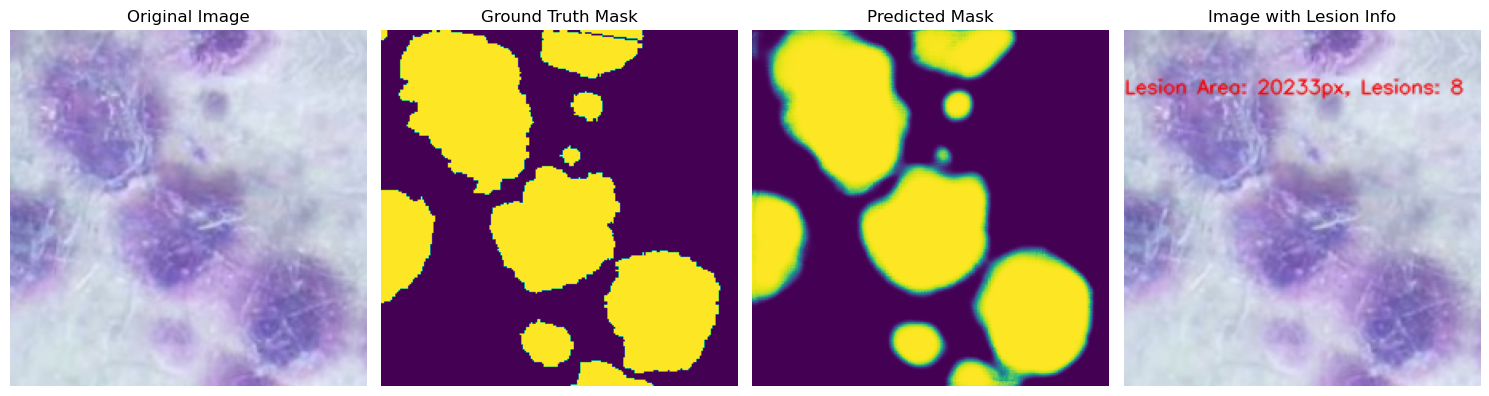

In [48]:
def overlay_lesion_info(image, total_lesion_area, num_lesions):
    info_text = f"Lesion Area: {total_lesion_area}px, Lesions: {num_lesions}"
    position = (0, 40)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.4
    font_color = (244, 000, 000)  # Green color
    thickness = 1
    line_type = cv2.LINE_AA
    cv2.putText(image, info_text, position, font, font_scale, font_color, thickness, line_type)
    return image

def visualize_with_lesions(image, true_mask, predicted_mask, total_lesion_area, num_lesions):
    # Overlay lesion information on the original image
    image_with_lesions = overlay_lesion_info(image.copy(), total_lesion_area, num_lesions)

    plt.figure(figsize=(15, 10))

    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(image.astype('uint8'))
    plt.title("Original Image")
    plt.axis("off")

    # Ground Truth Mask
    plt.subplot(1, 4, 2)
    plt.imshow(true_mask.squeeze())
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Predicted Mask
    plt.subplot(1, 4, 3)
    plt.imshow(predicted_mask.squeeze())
    plt.title("Predicted Mask")
    plt.axis("off")

    # Image with Lesion Information Overlay
    plt.subplot(1, 4, 4)
    plt.imshow(image_with_lesions)
    plt.title("Image with Lesion Info")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
visualize_with_lesions(test_image, true_mask, predicted_mask, total_lesion_area, num_lesions)
